# **IPMI19-20 Lab Session**
---
#**Semantic Segmentation Brain Tumours**

This tutorial is solving a real-world problem in segmenting brain tumours in slices of T1-weighted MR images using UNets. The dataset includes three types of tumour, complete with manually-generating 'ground-truth' masks. The task is to build 4 different models, one for each tumour type and one for **all** tumours, and compare their performance.<br>
**You should generate a brief table of results**, that shows the performance of the different models.<br>
The tutorial requires graphical processing units, **so before you start, make sure that you are connected to a GPU runtime.**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Get brain tumour data

##Get brain tumor images
Download using the wget system command

In [ ]:
!wget -O images.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EYtXUEOdt7VElTHk9lW--l0BY2CqOM4QSk1h5SjrQhRHEQ?e=nmUrKZ&download=1"

!wget -O masks.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EcJelcxZRYBNv2FyigSizQUBS6uY3cNuXs42-DZy_0dU0g?e=h0E2gV&download=1"

!wget -O labels.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EfXkm777vDVAjCbv_vTTQqYBs5eDOsmuu7Pm2ZgpsT5mPw?e=ZlcrfP&download=1"

--2020-02-17 11:49:20--  https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EYtXUEOdt7VElTHk9lW--l0BY2CqOM4QSk1h5SjrQhRHEQ?e=nmUrKZ&download=1
Resolving liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)... 13.107.136.9
Connecting to liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ucacjhc_ucl_ac_uk/Documents/Work/Teaching/UCL/IPMI%202019-20/brain_tumour_files/images.npy?&originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdWNhY2poY191Y2xfYWNfdWsvRVl0WFVFT2R0N1ZFbFRIazlsVy0tbDBCWTJDcU9NNFFTazFoNVNqclFoUkhFUT9ydGltZT01cnhfYlotejEwZw [following]
--2020-02-17 11:49:21--  https://liveuclac-my.sharepoint.com/personal/ucacjhc_ucl_ac_uk/Documents/Work/Teaching/UCL/IPMI%202019-20/brain_tumour_files/images.npy?&originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdWNhY2poY191Y2xfYWNfdWsvRVl0WFVFT2R0N1ZFbF

Check the files have loaded and are of the right size (~1.5GB, ~760MB; 25KB)

In [ ]:
!ls -lh

total 2.3G
-rw-r--r-- 1 root root 1.5G Feb  7 09:56 images.py
-rw-r--r-- 1 root root  25K Feb  7 09:49 labels.py
-rw-r--r-- 1 root root 767M Feb  7 09:53 masks.py
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


Load image and mask data as numpy arrays

In [ ]:
images = np.load('images.py')
masks = np.load('masks.py')
labels = np.load('labels.py')
print(images.shape)
print(images.dtype)
print(masks.shape)
print(masks.dtype)
print(labels.shape)
print(labels.dtype)

(3064, 512, 512)
int16
(3064, 512, 512)
bool
(3064,)
int64


Define dictionary of tumour categories

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


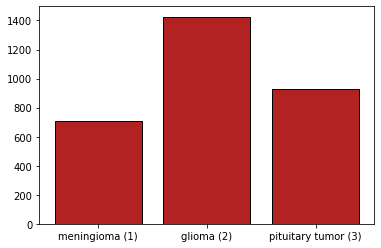

In [ ]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'],\
        color='firebrick', edgecolor='black')

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

#Visualisation
Load an image and matching tumour segmentation mask

Subject #1143
Tumour = glioma (2)


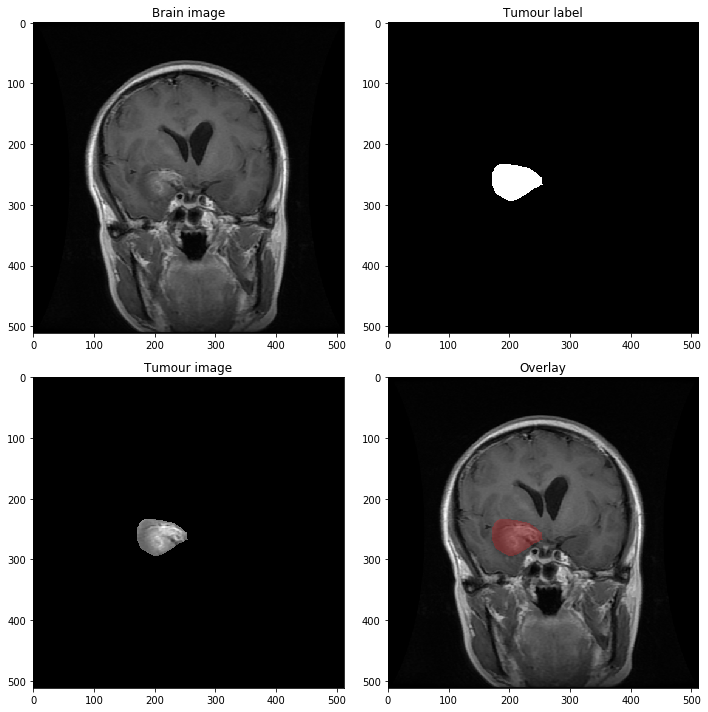

In [ ]:
# load a training image-mask pair
idx = random.randint(0,images.shape[0])
tumour_class = integer_to_class[str(labels[idx])]
print("Subject #" + str(idx))
print("Tumour = " + str(tumour_class))
image = images[idx,:,:]
mask = masks[idx,:,:]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(image, cmap = 'gray')
axes[0,1].imshow(mask, cmap = 'gray')
axes[1,0].imshow(image * mask, cmap = 'gray')
axes[1,1].imshow(image, cmap = 'gray')
axes[1,1].imshow(np.ma.masked_where(mask == False, mask), alpha=0.3, cmap = 'Set1') # set black pixel as transparent for the mask
axes[0,0].title.set_text('Brain image')
axes[0,1].title.set_text('Tumour label')
axes[1,0].title.set_text('Tumour image')
axes[1,1].title.set_text('Overlay')
plt.tight_layout()

##Plot multiple subjects

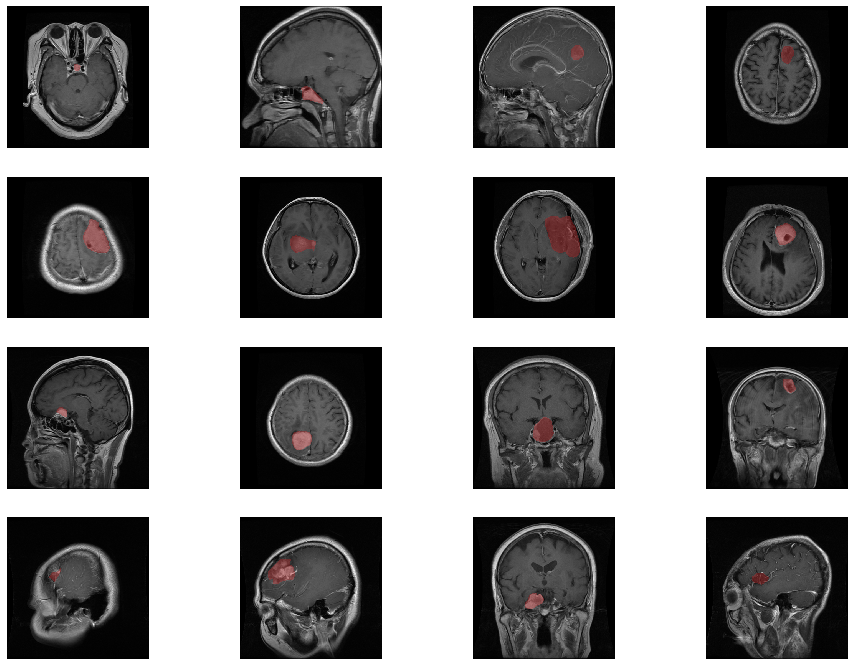

In [ ]:
plt.figure(figsize=(16, 12))
for i, idx in enumerate(np.random.randint(images.shape[0], size=16), start=1):
    plt.subplot(4, 4, i)
    plt.imshow(images[idx], cmap='gray')
    
    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')
    plt.axis('off')

## Divide dataset by tumour class

In [ ]:
print(images.shape)

meningioma_images = images[np.where(labels == 1)]
meningioma_masks = masks[np.where(labels == 1)]
print(meningioma_images.shape)

glioma_images = images[np.where(labels == 2)]
glioma_masks = masks[np.where(labels == 2)]
print(glioma_images.shape)

pituitary_images = images[np.where(labels == 3)]
pituitary_masks = masks[np.where(labels == 3)]
print(pituitary_images.shape)

(3064, 512, 512)
(708, 512, 512)
(1426, 512, 512)
(930, 512, 512)


#UNet for image segmentation

##Create training and test data
Need to randomly select a proportion of data for training and testing

In [ ]:
def train_test_split(image_data, mask_data, train_proportion):
    np.random.seed = 37
    train_proportion = train_proportion
    train_index = np.random.choice(image_data.shape[0], size = int(image_data.shape[0] * train_proportion), replace = False)
    print(str("Training set = ") + str("{:.0%}".format(train_proportion)) + str(", n = ") + str(len(train_index)))
    
    x_train = image_data[train_index, :, :]
    x_train = np.expand_dims(x_train, axis=3)

    y_train = mask_data[train_index, :, :]
    y_train = np.expand_dims(y_train, axis=3)

    x_test = np.delete(image_data, train_index, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = np.delete(mask_data, train_index, axis=0)
    y_test = np.expand_dims(y_test, axis=3)
    return x_train, y_train, x_test, y_test

Generate your training and test data. The inputs here can be images (i.e., all tumour types), glioma_images, pituitary_images or meningioma_images. The corresponding mask file should also be included.<br>
You can set the proportion of data to be used for training; the remainder will be used for testing.

In [ ]:
# choose input data
input_images = glioma_images
input_masks = glioma_masks
# run train_test_split function
x_train, y_train, x_test, y_test = train_test_split(image_data = input_images, mask_data = input_masks, train_proportion = 0.8)

Training set = 80%, n = 1140


Check data shapes and formats

In [ ]:
print(y_train.shape)
print(x_test.shape)
print(x_test.dtype)
print(y_train.dtype)

(1140, 512, 512, 1)
(286, 512, 512, 1)
int16
bool


###Check that the data are properly specified

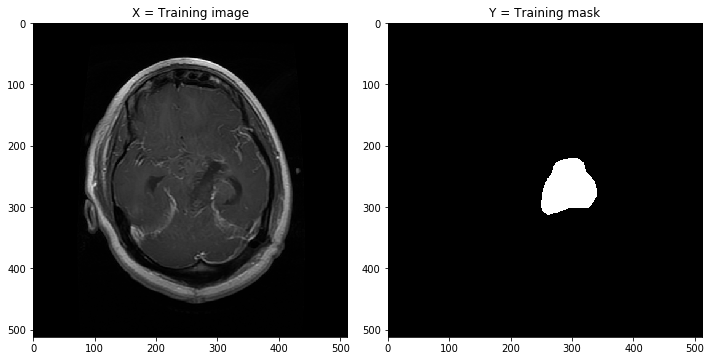

In [ ]:
idx = random.randint(0,x_train.shape[0])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(np.squeeze(x_train[idx]), cmap='gray')
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax1.title.set_text('X = Training image')
ax2.title.set_text('Y = Training mask')
plt.tight_layout()

Plot points in x_train and y_train

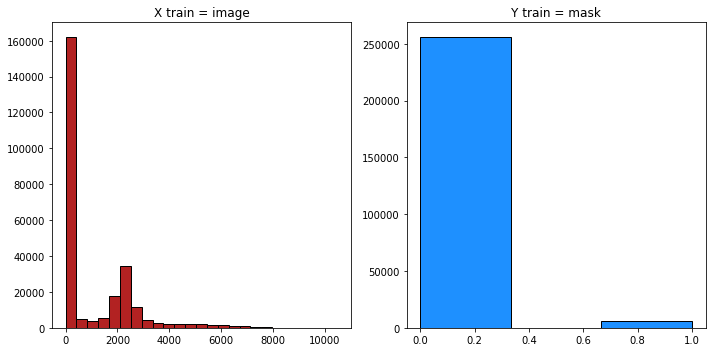

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.hist(np.concatenate(x_train[idx]), bins=25, facecolor='firebrick', edgecolor='black')
ax2.hist(np.concatenate(y_train[idx].astype(np.int8)), bins=3, facecolor='dodgerblue', edgecolor='black')
ax1.title.set_text('X train = image')
ax2.title.set_text('Y train = mask')
plt.tight_layout()

##Custom loss functions and performance metrics


Intersection over union AKA Jaccard Index. Area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.

In [ ]:
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(y_true, y_pred):
    return 1-iou_coef(y_true, y_pred)

Alternative implementation of the Jaccard Index

In [ ]:
from tensorflow.keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

Dice overlap coefficient. Double the sum of the intersection over the total size of the area of both regions.

In [ ]:
from tensorflow.keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

##Define UNet architecture
#### The following elements can be included the architecture:
- 2D convolution with padded feature maps (for convenience in working out the sizes at different resolution levels)
- nonlinear activation
- pooling layer
- normalisation layer
- dropout

### Function to define convolutional blocks
Adds two convolutional layers with the parameters passed to it.


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, activ_func='relu', batchnorm = True, pad='same'):
    # first layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    # second layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    return block

### Function to define UNet layers
Changing variables such as the number of filters, dropout rate and pool size for the max-pooling layer will influence prediction performance.

In [ ]:
def unet(input_img, n_filters=16, dropout=0.1, pool_size=(2,2), pad='same'):
  s = tf.keras.layers.Lambda(lambda x: x / 255)(input_img)
  # Contracting path
  c1 = conv2d_block(input_img, n_filters=n_filters)
  c1 = tf.keras.layers.Dropout(dropout)(c1)
  p1 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c1)
 
  c2 = conv2d_block(p1, n_filters=n_filters * 2)
  c2 = tf.keras.layers.Dropout(dropout)(c2)
  p2 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c2)
 
  c3 = conv2d_block(p2, n_filters=n_filters * 4)
  c3 = tf.keras.layers.Dropout(dropout)(c3)
  p3 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c3)
  
  c4 = conv2d_block(p3, n_filters=n_filters * 8)
  c4 = tf.keras.layers.Dropout(dropout)(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c4)
  
  c5 = conv2d_block(p4, n_filters=n_filters * 16)
  c5 = tf.keras.layers.Dropout(dropout)(c5)
    
  # Expanding path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad)(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = conv2d_block(c6, n_filters=n_filters * 8)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad)(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = conv2d_block(c7, n_filters=n_filters * 4)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad)(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = conv2d_block(c8, n_filters=n_filters * 2)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=pad)(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = conv2d_block(c9, n_filters=n_filters)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = tf.keras.models.Model(inputs=[input_img], outputs=[outputs])
  return model

##Generate model
Can set input dimensions, channels and other parameters, as well as chose the optimiser. Adam is commonly used for Unets.
The loss function for image segmentation can be binary cross-entropy, treating segmentation as a voxel classification problem. Probabilitic (soft) Dice Coefficient is also widely used.

In [ ]:
IMG_WIDTH = x_train.shape[1]
IMG_HEIGHT = x_train.shape[2]
IMG_CHANNELS = 1
input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = unet(input_img, dropout=0.1, pool_size=(2,2), pad='same')
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=[dice_coef, 'accuracy'])

Print out a summary of the model's architecture. Note how many parameters are destined to be optimised during training.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512, 512, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 512, 512, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

## Visualise network
Uses Keras utilities

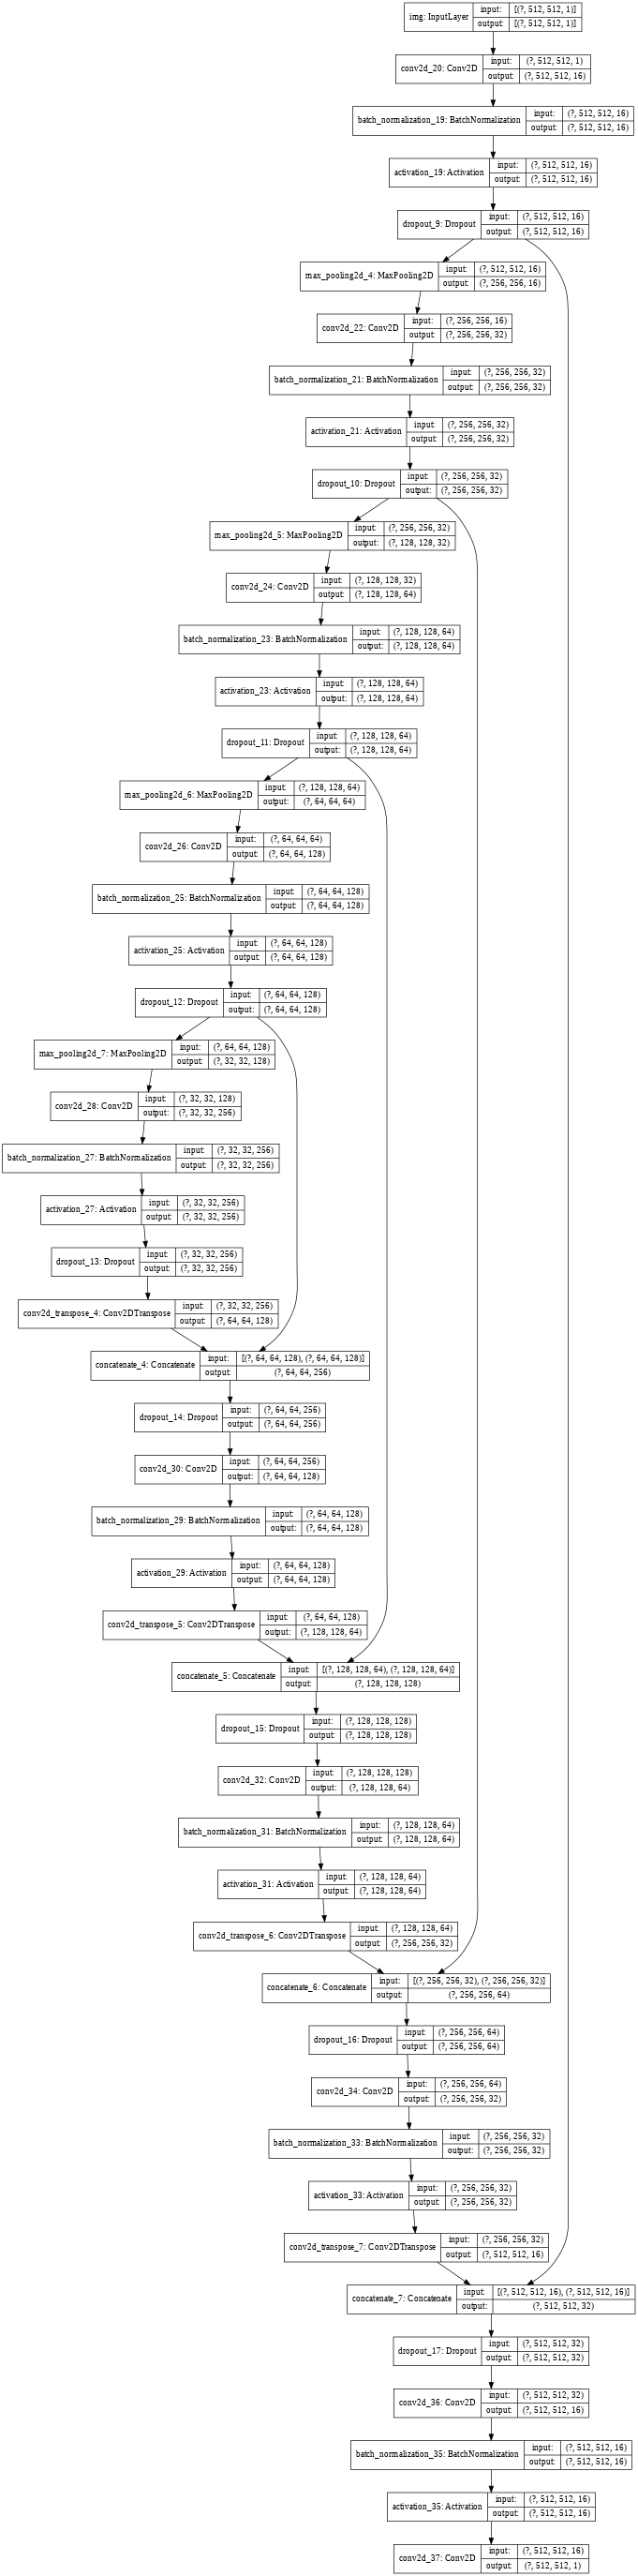

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, dpi=48)

Save model architecture to JSON

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Read in and print JSON file. This is the full details of your architecture.

In [ ]:
json.load(open('model.json', 'r'))

{'backend': 'tensorflow',
 'class_name': 'Model',
 'config': {'input_layers': [['img', 0, 0]],
  'layers': [{'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 512, 512, 1],
     'dtype': 'float32',
     'name': 'img',
     'ragged': False,
     'sparse': False},
    'inbound_nodes': [],
    'name': 'img'},
   {'class_name': 'Conv2D',
    'config': {'activation': 'linear',
     'activity_regularizer': None,
     'bias_constraint': None,
     'bias_initializer': {'class_name': 'Zeros',
      'config': {'dtype': 'float32'}},
     'bias_regularizer': None,
     'data_format': 'channels_last',
     'dilation_rate': [1, 1],
     'dtype': 'float32',
     'filters': 16,
     'kernel_constraint': None,
     'kernel_initializer': {'class_name': 'VarianceScaling',
      'config': {'distribution': 'truncated_normal',
       'dtype': 'float32',
       'mode': 'fan_in',
       'scale': 2.0,
       'seed': None}},
     'kernel_regularizer': None,
     'kernel_size': [3, 3],
     

#Train model

Create checkpoints for logging model performance during training and define callbacks to enable early stopping. Changing the patience argument will influence when early stopping happends.<br>
If you get out of memory errors (OOM), you can try reducing the batch size. Training will take longer, but should give similar results. Altering the early stopping criteria (e.g., min delta), the maximum number of epochs or even the optimiser's learning rate will reduce training time.

In [ ]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
  tf.keras.callbacks.ModelCheckpoint("best_model.ckpt", save_best_only=True, verbose=1) 
]

**Fit model**


In [ ]:
results = model.fit(x=x_train, y=y_train,
                    validation_split=0.2,
                    batch_size=12,
                    epochs=20,
                    callbacks=callbacks)

Train on 912 samples, validate on 228 samples
Epoch 1/20
900/912 [============================>.] - ETA: 0s - loss: 0.5880 - dice_coef: 0.0396 - acc: 0.7878
Epoch 00001: val_loss improved from inf to 4.30383, saving model to best_model.ckpt
912/912 [==============================] - 66s 72ms/sample - loss: 0.5857 - dice_coef: 0.0398 - acc: 0.7901 - val_loss: 4.3038 - val_dice_coef: 0.0562 - val_acc: 0.6686
Epoch 2/20
900/912 [============================>.] - ETA: 0s - loss: 0.3404 - dice_coef: 0.0327 - acc: 0.9774
Epoch 00002: val_loss improved from 4.30383 to 0.29102, saving model to best_model.ckpt
912/912 [==============================] - 61s 67ms/sample - loss: 0.3397 - dice_coef: 0.0326 - acc: 0.9775 - val_loss: 0.2910 - val_dice_coef: 0.0290 - val_acc: 0.9780
Epoch 3/20
900/912 [============================>.] - ETA: 0s - loss: 0.2546 - dice_coef: 0.0359 - acc: 0.9781
Epoch 00003: val_loss improved from 0.29102 to 0.22997, saving model to best_model.ckpt
912/912 [==============

### Visualise model training

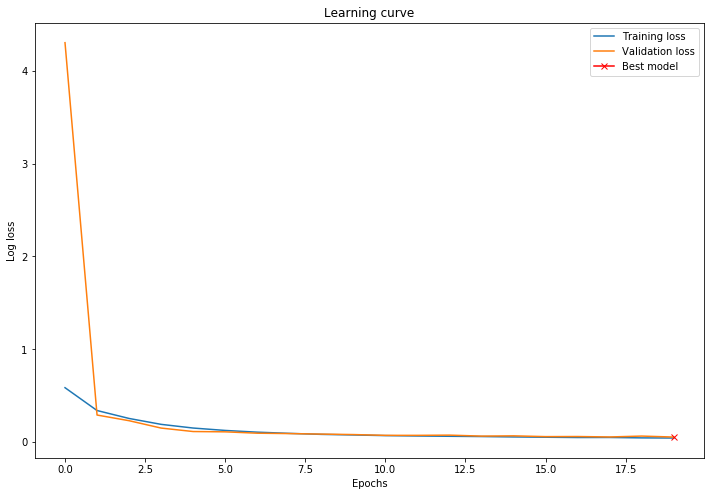

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="Training loss")
plt.plot(results.history["val_loss"], label="Validation loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();

After training you can look at various various parametetrs of the model, such as the learning rate and weight decay.

In [ ]:
from tensorflow.keras import backend as K
print("weight decay = "  + str(K.eval(model.optimizer.decay)))
print("learning rate = "  + str(K.eval(model.optimizer.lr)))

weight decay = 0.0
learning rate = 0.001


#Evaluate performance

Load checkpoint data and get performance on test data using training weights

In [ ]:
model.load_weights('best_model.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

286/286 - 7s - loss: 0.0571 - dice_coef: 0.3142 - acc: 0.9802


[0.05706070337470595, 0.31418788, 0.9802449]

##Apply to test data
This step generates the predicted mask images in 2D

In [ ]:
predict = model.predict(x_test, verbose=1)
predict = (predict > 0.5).astype(np.int8)

286/286 [==============================] - 4s 15ms/sample


##Calculate Dice overlap coefficient
As above Dice is 2 * the area of overlap divided by the total number of pixels in both images. This function can be used to test the overlap with a single predicted mask.

In [ ]:
def get_dice(idx):
  seg = np.squeeze(predict[idx])
  gt = np.squeeze(y_test[idx])
  dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
  return dice

Calculate the Dice score for all subjects and summarise.

In [ ]:
dices = []
for i in range(x_test.shape[0]):
  dices.append(get_dice(i))

print('mean = ' + '{:.3f}'.format(np.mean(dices)))
print('median = ' + '{:.3f}'.format(np.median(dices)))
print('SD = ' + '{:.3f}'.format(np.std(dices)))

mean = 0.305
median = 0.234
SD = 0.294


Find the subject with the highest Dice overlap

In [ ]:
maxDice = np.where(dices == np.amax(dices))
print(maxDice[0])

[132]


In [ ]:
print('{:.2f}'.format(get_dice(maxDice[0])))

0.93


Visualise the predictions for the subject with highest overlap

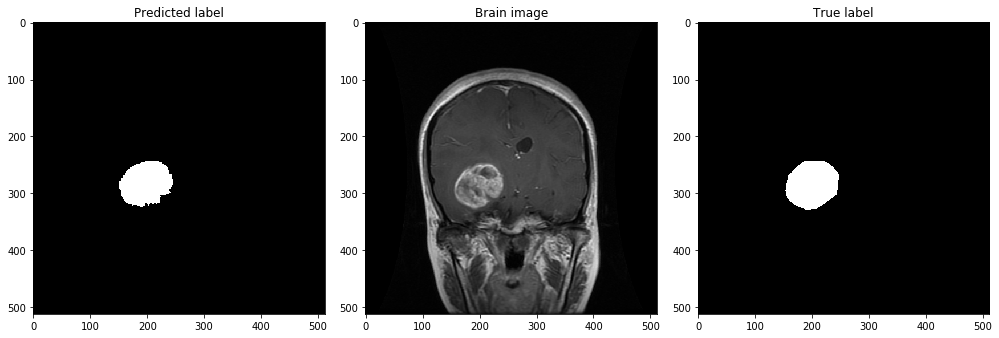

In [ ]:
idx = maxDice[0]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
ax1.imshow(np.squeeze(predict[idx]), cmap='gray')
ax2.imshow(np.squeeze(x_test[idx]), cmap='gray')
ax3.imshow(np.squeeze(y_test[idx]), cmap='gray')
ax1.title.set_text('Predicted label')
ax2.title.set_text('Brain image')
ax3.title.set_text('True label')
plt.tight_layout()

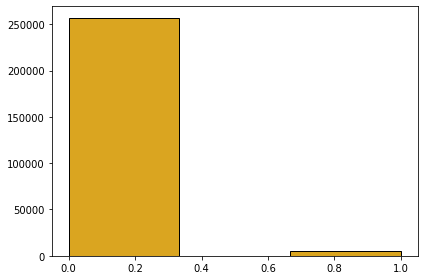

In [ ]:
idx = maxDice[0]
plt.figure(figsize=(6,4))
plt.hist(np.concatenate(np.squeeze(predict[idx])), bins=3, facecolor='goldenrod', edgecolor='black')
plt.tight_layout()

## Correlations between mask volumes

Function to get the size (i.e., number of pixels) for the true mask and predicted mask

In [ ]:
def get_mask_sizes(idx):
    true_mask_size = np.count_nonzero(y_test[idx])
    predicted_mask_size = np.count_nonzero(predict[idx])
    return true_mask_size, predicted_mask_size

Run on example subject

In [ ]:
get_mask_sizes(idx = maxDice[0])

(6257, 5678)

Loop through all the test data

In [ ]:
true_masks = [get_mask_sizes(x)[0] for x in range(y_test.shape[0])]
predicted_masks = [get_mask_sizes(x)[1] for x in range(y_test.shape[0])]

Correlation between the true mask sizes and predicted mask sizes

In [ ]:
print('{:.3f}'.format(np.corrcoef(true_masks, predicted_masks)[0,1]))

0.158


Scatterplot of the true mask sizes and predicted mask sizes

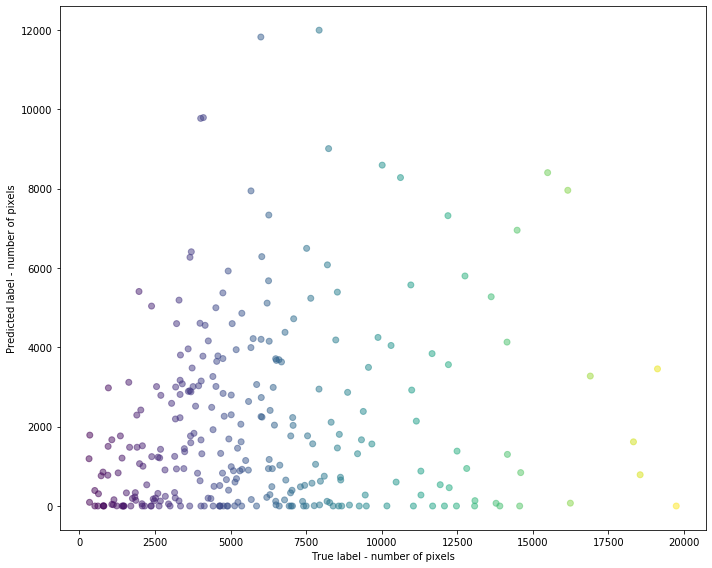

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(true_masks, predicted_masks, c=true_masks, alpha = 0.5)
plt.xlabel("True label - number of pixels")
plt.ylabel("Predicted label - number of pixels")
plt.tight_layout()

#Data augmentation
Create synthetic data based on the real data to augment the training process.<br>
Example data augmentation with translations, flips and rotations

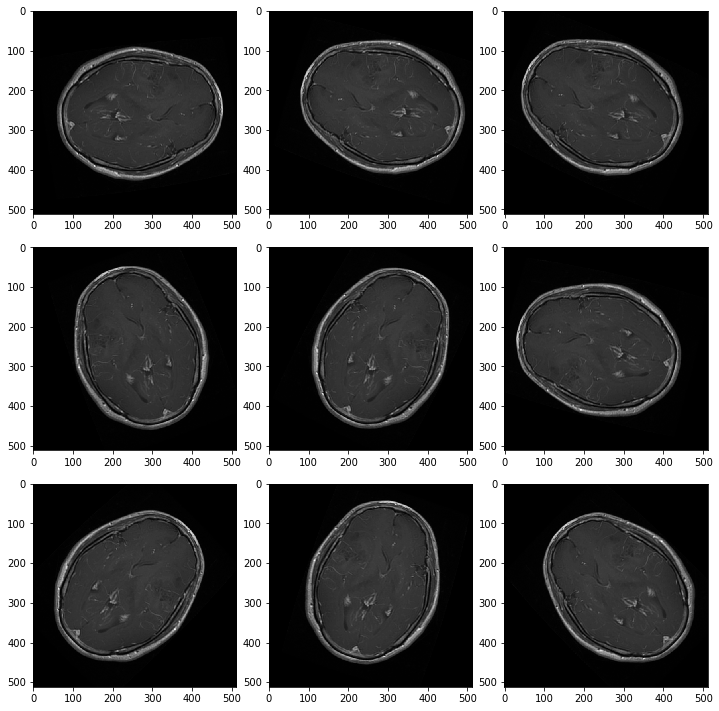

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-20,20],
                             height_shift_range=[-10,10],
                             horizontal_flip=True,
                             rotation_range=90)
# prepare iterator
idx = 1
samples = np.expand_dims(np.expand_dims(images[idx,:,:],-1),0)
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i,)
	# generate batch of images
	batch = it.next()
	image = batch[0]
	# plot raw pixel data
	plt.imshow(np.squeeze(image,-1), cmap='gray')
plt.tight_layout()